In [1]:


%matplotlib inline
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from datetime import timedelta
import datetime as dt
import matplotlib.pyplot as plt
# 설정값을 이렇게 설정도 한다

plt.rcParams['figure.figsize'] = [16, 10]
import seaborn as sns
# 캐글에서 많이 사용하는 라이브러리
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
import warnings
warnings.filterwarnings('ignore')




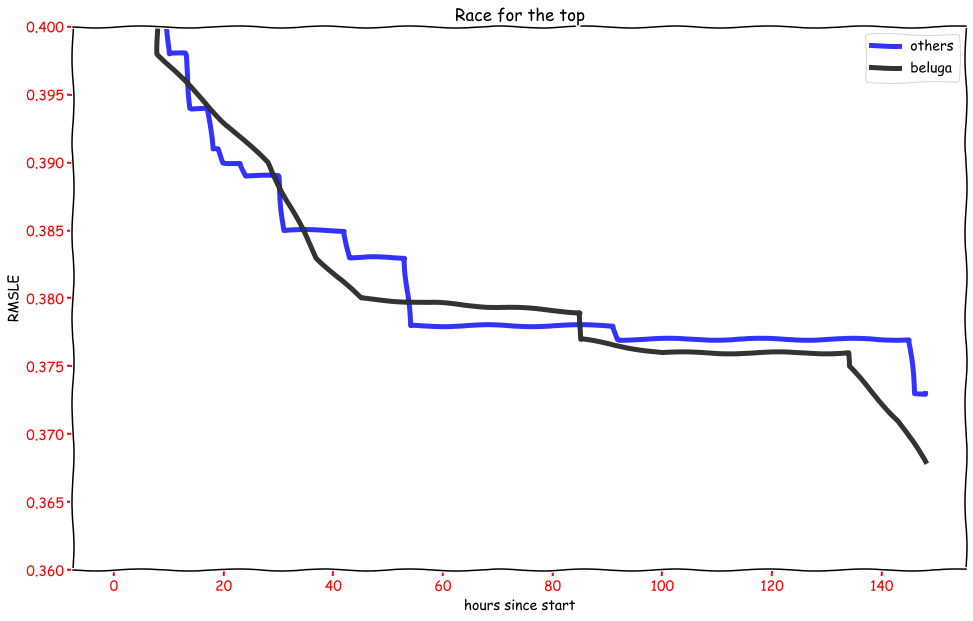

In [2]:

beluga = pd.DataFrame({'since_start_hour': [8.0, 8.0, 20.0, 28.0, 37.0, 45.0, 85.0, 85.0, 100.0, 134.0, 134.0, 143.0, 148.0],
                       'Score': [ 0.400,  0.398,  0.393,  0.390,  0.383,  0.380,  0.379,  0.377,  0.376,  0.376,  0.375,  0.371,  0.368]})
others = pd.DataFrame({'since_start_hour': [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,68,69,70,71,72,73,74,75,76,77,78,79,80,81,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148],
                        'BestScore': [.452,.452,.452,.452,.452,.452,.421,.421,.421,.406,.398,.398,.398,.398,.394,.394,.394,.394,.391,.391,.390,.390,.390,.390,.389,.389,.389,.389,.389,.389,.389,.385,.385,.385,.385,.385,.385,.385,.385,.385,.385,.385,.385,.383,.383,.383,.383,.383,.383,.383,.383,.383,.383,.383,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.378,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.377,.373,.373,.373]})

#
with plt.xkcd():
    # This figure will be in XKCD-style ?
    fig, ax = plt.subplots()
    # alpha : 투명도

    ax.plot(others.since_start_hour.values, others.BestScore.values, 'b', alpha=0.8, lw=5, label='others')
    ax.plot(beluga.since_start_hour.values, beluga.Score.values, 'k', alpha=0.8, lw=5, label='beluga')
    ax.set_ylim(0.36, 0.4)
    ax.legend(loc=0)
    ax.set_xlabel('hours since start')
    ax.set_ylabel('RMSLE')
    ax.set_title('Race for the top')

    ax.tick_params(direction='out' , length=6,width=2,colors='r')

    plt.show()

In [3]:
### Data understanding



In [4]:
np.random.seed(1989)
N = 100000  # number of sample rows in plots
t0 = dt.datetime.now()


train = pd.read_csv('C:\\Users\\tjdal\\PycharmProjects\\Kaggle\\newyorkcitytaxi\\train\\train.csv')
test = pd.read_csv('C:\\Users\\tjdal\\PycharmProjects\\Kaggle\\newyorkcitytaxi\\test\\test.csv')

In [5]:
train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


In [6]:

train

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435
...,...,...,...,...,...,...,...,...,...,...,...
1458639,id2376096,2,2016-04-08 13:31:04,2016-04-08 13:44:02,4,-73.982201,40.745522,-73.994911,40.740170,N,778
1458640,id1049543,1,2016-01-10 07:35:15,2016-01-10 07:46:10,1,-74.000946,40.747379,-73.970184,40.796547,N,655
1458641,id2304944,2,2016-04-22 06:57:41,2016-04-22 07:10:25,1,-73.959129,40.768799,-74.004433,40.707371,N,764
1458642,id2714485,1,2016-01-05 15:56:26,2016-01-05 16:02:39,1,-73.982079,40.749062,-73.974632,40.757107,N,373


In [7]:
sample_submission = pd.read_csv('C:\\Users\\tjdal\\PycharmProjects\\Kaggle\\newyorkcitytaxi\\sample_submission\\sample_submission.csv')


In [11]:
print('we have {} train set'.format(len(train.shape[0])))
print('we have {} test set'.format(len(test.shape[0])))

TypeError: object of type 'int' has no len()

In [12]:
# nunique 유니크 개수
#
print('unique id : ' , train.id.nunique())

unique id :  1458644


In [13]:
import numpy as np

# intersect1d args1에 있지만 arg2에 없는 것
len(np.intersect1d(train.id.values, test.id.values))

0

In [14]:
# | 합집합이고 문자열로 뺐을 때 n만 y만 있다면 이상치 없다는 것 이런 행위를 왜 하는 지는
# 현업에서 겪어보면 축적되는 경험이다 생각해보니
print('The store_and_fwd_flag has only two values {}.'.format(str(set(train.store_and_fwd_flag.unique()) | set(test.store_and_fwd_flag.unique()))))

The store_and_fwd_flag has only two values {'N', 'Y'}.


In [ ]:
test.dtypes


In [ ]:
train.dtypes

In [ ]:
# type change

In [15]:
train['pickup_datetime'] =pd.to_datetime(train.pickup_datetime)
test['pickup_datetime'] =pd.to_datetime(test.pickup_datetime)



train.loc[:, 'pickup_date'] = train['pickup_datetime'].dt.date
test.loc[:, 'pickup_date'] = test['pickup_datetime'].dt.date

train['dropoff_datetime'] = pd.to_datetime(train.dropoff_datetime)

In [16]:
# Y is 1 N is 0 trick


train['store_and_fwd_flag']= 1 * (train.store_and_fwd_flag == 'Y')
test['store_and_fwd_flag']= 1 * (train.store_and_fwd_flag == 'Y')

In [17]:
# real y check
# csv헤더컬럼이 1번 차지하고 인덱스는 0부터 시작하니 데이터프레임에서는 row -2가 될수있다.
train.iloc[348,:]

id                              id1633648
vendor_id                               1
pickup_datetime       2016-06-20 14:19:16
dropoff_datetime      2016-06-20 14:34:34
passenger_count                         1
pickup_longitude               -73.977905
pickup_latitude                 40.754871
dropoff_longitude              -73.952774
dropoff_latitude                40.768166
store_and_fwd_flag                      1
trip_duration                         918
pickup_date                    2016-06-20
Name: 348, dtype: object

In [18]:
# pickup_datetime type is datetime so on x(datetime).total_seconds method 사용 가능

# map은 series에 apply는 dataframe

train['check_trip_duration'] = (train['dropoff_datetime'] - train['pickup_datetime']).map(lambda x: x.total_seconds())
# preprocess는 왜 ? -> 모델에 넣기 좋게 피쳐 가공 필요 (사전에 모델 설계 필요하다는 뜻)


In [19]:
# 기존에 주어진 값과 비교 의심
# 시각화해서 탐색한다 의심점을 추상적 객체를 시각화해서

duration_difference = train[np.abs(train['check_trip_duration'].values  - train['trip_duration'].values) > 1]
#%
print('Trip_duration and datetimes are ok.') if len(duration_difference[['pickup_datetime', 'dropoff_datetime', 'trip_duration', 'check_trip_duration']]) == 0 else print('Ooops.')

Trip_duration and datetimes are ok.


In [20]:


train['trip_duration'].max() // 3600

979

In [21]:
##We can see that the max trip_duration is ~ 1000 hours.
# Fortunately the evaluation metric is RMSLE and not RMSE
# . Outliers will cause less trouble.
# We could logtransform our target label and use RMSE during training.
# ROOT 를 사용하기 때문에 아웃라이어의 trouble이 적어진다는 뜻

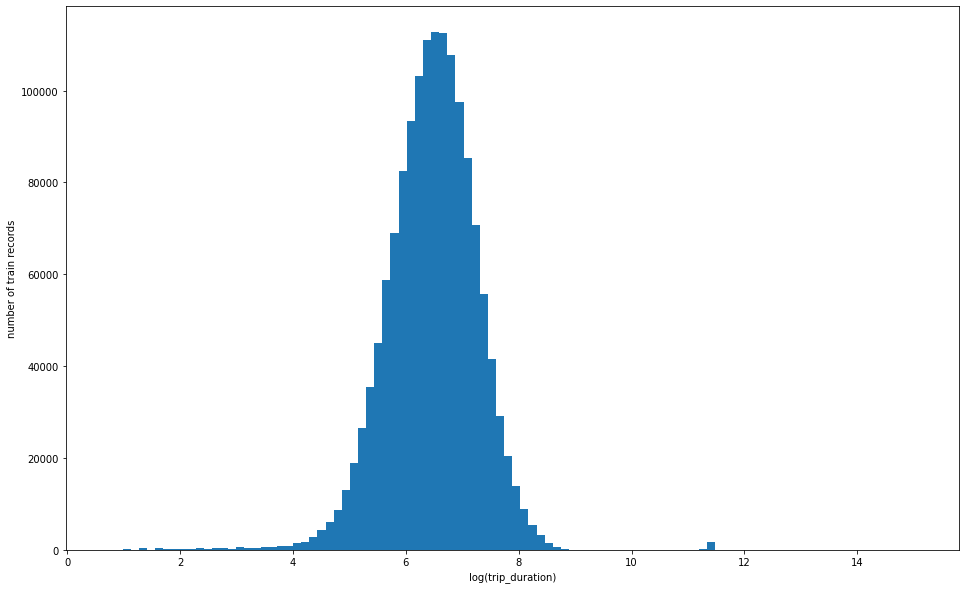

In [22]:
# 분포가 이쁘지 않고 outlier가 주는 영향이 너무 크기 때문에? log를 취해서 outlier 영향 줄이도록 이건 아니고 이미 평가지표가 rmse이기떄문
train['log_trip_duration'] = np.log(train['trip_duration'].values + 1)
# plt.hist(train['trip_dupration'].values, bin =100) # 그래프가 보기 좋지 않음
plt.hist(train['log_trip_duration'].values, bins=100)
plt.xlabel('log(trip_duration)')
plt.ylabel('number of train records')
plt.show()


In [23]:
# 데이터프레임 boolean mask 씌윅
#mask = train.groupby('pickup_date').count() < 4000
#mask


In [24]:
train.dtypes()

TypeError: 'Series' object is not callable

In [25]:
train[train['pickup_date'] =='2016-01-01']

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_date,check_trip_duration,log_trip_duration


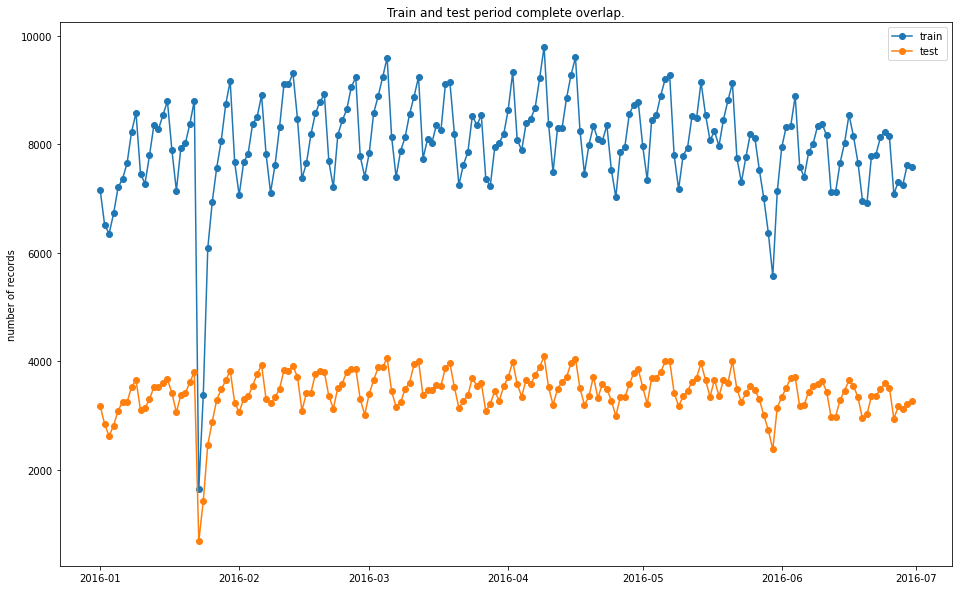

In [26]:

plt.plot(train.groupby('pickup_date').count()[['id']], 'o-', label='train')
plt.plot(test.groupby('pickup_date').count()[['id']], 'o-', label='test')
plt.title('Train and test period complete overlap.')
plt.legend(loc=0)
plt.ylabel('number of records')
plt.show()

In [27]:
# 특정 값 찾아보기
df = train.groupby('pickup_date').count()
# iloc 에 true false mask 는 넘겨 주지말고
# df.iloc[(df['id']<2000) ]
df.loc[(df['id']<2000) ]

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,check_trip_duration,log_trip_duration
pickup_date,,,,,,,,,,,,,
2016-01-23,1648,1648,1648,1648,1648,1648,1648,1648,1648,1648,1648,1648,1648


In [28]:
#def foo1(x):
#    if x < 2000:
#       return x

#df = train.groupby('pickup_date').count()['id'].map(foo1)
#df
#lambda condition 단독 if 문 안되고 else 가 필요
df = train.groupby('pickup_date').count()['id'].apply(lambda x: x if x< 2000 else False)

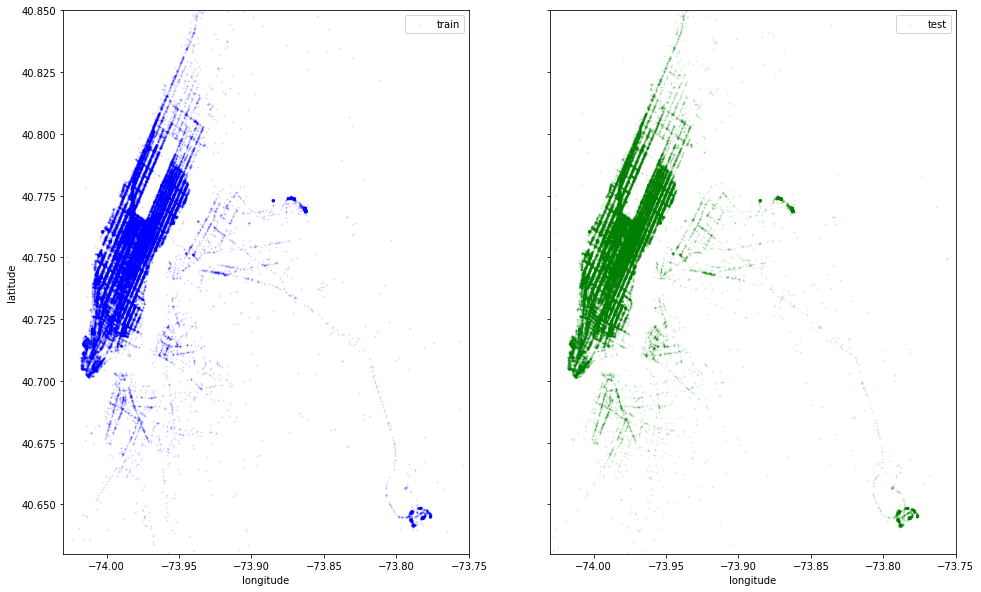

In [38]:
# 실제 뉴욕 경위도 찾기
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)

# share , sharey 축을 공유


fix , ax = plt.subplots(ncols=2, sharex=True , sharey =True)

# s는 marker size
ax[0].scatter(train['pickup_longitude'].values[:N], train['pickup_latitude'].values[:N] , color = 'blue' , s=1, label='train' ,alpha=0.1)
ax[1].scatter(test['pickup_longitude'].values[:N], test['pickup_latitude'].values[:N],
              color='green', s=1, label='test', alpha=0.1)
fig.suptitle('Train and test area complete overlap.')
ax[0].legend(loc=0)
ax[0].set_ylabel('latitude')
ax[0].set_xlabel('longitude')
ax[1].set_xlabel('longitude')
ax[1].legend(loc=0)
plt.ylim(city_lat_border)
plt.xlim(city_long_border)
plt.show()
# 갑자기 택시 줄어든 이유 ? -> 폭설을 생각

In [ ]:
## Feature Extraction
# 아래로 쌓는다 like concat axis = 0
coords = np.vstack((train[['pickup_latitude', 'pickup_longitude']].values,
                    train[['dropoff_latitude', 'dropoff_longitude']].values,
                    test[['pickup_latitude', 'pickup_longitude']].values,
                    test[['dropoff_latitude', 'dropoff_longitude']].values))

In [33]:
train[['pickup_latitude', 'pickup_longitude']].values

array([[ 40.76793671, -73.98215485],
       [ 40.73856354, -73.98041534],
       [ 40.7639389 , -73.97902679],
       ...,
       [ 40.76879883, -73.95912933],
       [ 40.74906158, -73.98207855],
       [ 40.78174973, -73.97953796]])

In [34]:
coords

array([[ 40.76793671, -73.98215485],
       [ 40.73856354, -73.98041534],
       [ 40.7639389 , -73.97902679],
       ...,
       [ 40.74866486, -73.87660217],
       [ 40.89178848, -73.85426331],
       [ 40.76937866, -73.96932983]])

In [35]:
test[['dropoff_latitude', 'dropoff_longitude']]

,dropoff_latitude,dropoff_longitude
0,40.756680,-73.990173
1,40.655403,-73.959808
2,40.729523,-73.986160
3,40.730469,-73.986427
4,40.755890,-73.961510
...,...,...
625129,40.733643,-74.001251
625130,40.782467,-73.953407
625131,40.748665,-73.876602
625132,40.891788,-73.854263


In [36]:
### fit and transform
# https://builtin.com/data-science/step-step-explanation-principal-component-analysis pca 이해
# PCA쓸 생각은 어떻게? -> 데이터가 다차원의 데이터니까 1차원으로 PCA 분석을 할 생각을 할 수 있다
pca = PCA().fit(coords)
# 여기서는 dimension reduction 이 아니라 transform 2D ->2D 로 한다 값을 줄이기 위함 아래의 plot에서

In [40]:

train['pickup_pca0'] = pca.transform(train[['pickup_latitude', 'pickup_longitude']])[:, 0]
train['pickup_pca1'] = pca.transform(train[['pickup_latitude', 'pickup_longitude']])[:, 1]
train['dropoff_pca0'] = pca.transform(train[['dropoff_latitude', 'dropoff_longitude']])[:, 0]
train['dropoff_pca1'] = pca.transform(train[['dropoff_latitude', 'dropoff_longitude']])[:, 1]
test['pickup_pca0'] = pca.transform(test[['pickup_latitude', 'pickup_longitude']])[:, 0]
test['pickup_pca1'] = pca.transform(test[['pickup_latitude', 'pickup_longitude']])[:, 1]
test['dropoff_pca0'] = pca.transform(test[['dropoff_latitude', 'dropoff_longitude']])[:, 0]
test['dropoff_pca1'] = pca.transform(test[['dropoff_latitude', 'dropoff_longitude']])[:, 1]

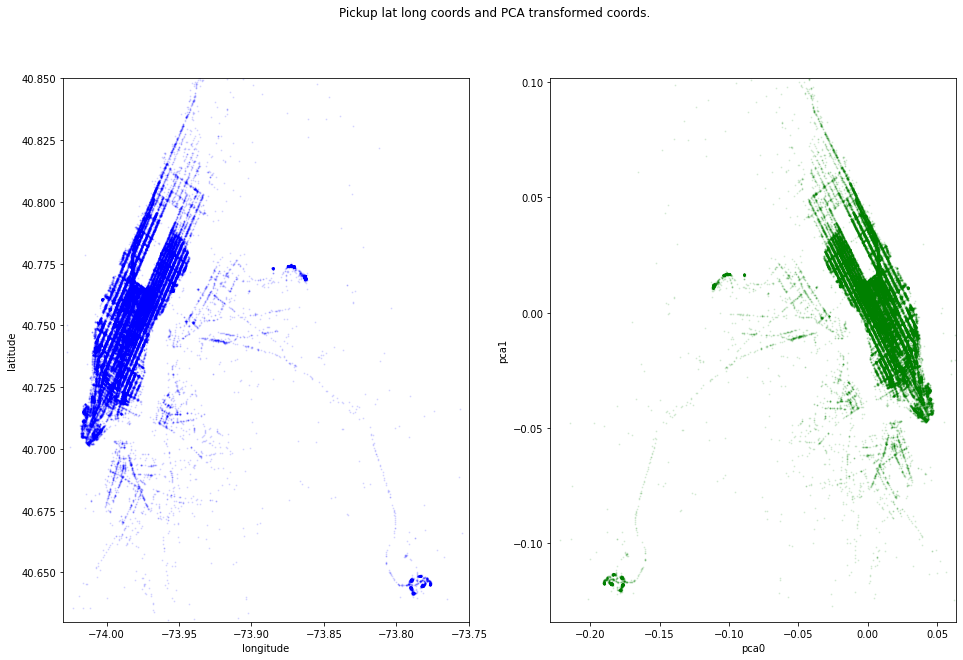

In [41]:
fig, ax = plt.subplots(ncols=2)
ax[0].scatter(train['pickup_longitude'].values[:N], train['pickup_latitude'].values[:N],
              color='blue', s=1, alpha=0.1)
ax[1].scatter(train['pickup_pca0'].values[:N], train['pickup_pca1'].values[:N],
              color='green', s=1, alpha=0.1)
fig.suptitle('Pickup lat long coords and PCA transformed coords.')
ax[0].set_ylabel('latitude')
ax[0].set_xlabel('longitude')
ax[1].set_xlabel('pca0')
ax[1].set_ylabel('pca1')
ax[0].set_xlim(city_long_border)
ax[0].set_ylim(city_lat_border)
pca_borders = pca.transform([[x, y] for x in city_lat_border for y in city_long_border])
ax[1].set_xlim(pca_borders[:, 0].min(), pca_borders[:, 0].max())
ax[1].set_ylim(pca_borders[:, 1].min(), pca_borders[:, 1].max())
plt.show()

In [42]:
# https://www.google.com/search?q=harversine&oq=harversine&aqs=chrome..69i57j46i10j0i512j0i10i512j0i10j46i10j0i10l2j46i10.2640j0j4&sourceid=chrome&ie=UTF-8
"""""
Distance
Let's calculate the distance (km) between pickup and dropoff points.
Currently Haversine is used, geopy has another heuristics (vincenty() or great_circle()) if you prefer.
The cabs are not flying and we are in New York so we could check the Manhattan (L1) distance too :)
pd.DataFrame.apply() would be too slow so the haversine function is rewritten to handle arrays.
We extraxt the middle of the path as a feature as well.
"""""
# 거리는 왜 구하지? -> 우선 택시 승차지점과 하차지점을 구하는 건데

# '구'의 거리를 구한다
# haversine 공식 구현
# https://en.wikipedia.org/wiki/Haversine_formula#Formulation
# 데이터에 따라 방법을 적용하는 것이고 상황에 따라 집중하면 된다
#  위도나 경도는 지구 중심을 기반으로 하는 각도이기때문에 라디안으로 변환가능 <ㅡ 이런 걸 찾는다 답답한 것
def haversine_array(lat1, lng1, lat2, lng2):
    # radian은 호도법에 의한 각도의 단위

    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km earth 구의 반경
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

In [43]:
# 맨해튼  거리는 유클리드 거리처럼 건물 블럭들이 있다고 했을 때 건물을 뚫고 지나갈 수 없다고 가정한 L1 distance로 불린다#
# taxi이므로 맨해튼거리
# 여기서 dummy 는 ? 이 단어도 그냥 안 넘어 간다 하나하나를 (운동도 공부도 이렇게 해야한다^^)
# 실제로 두 점 사이에서 가로질러가는 게아니라면 왼쪽 방향도 있고 오른 쪽 방향도 있으므로 둘 다 구하는 식
#
def dummy_manhattan_distance(lat1, lng1, lat2, lng2):
    # 좌표의 구성을 잘 보고 ppt로 시각화 해보면 안다
    a = haversine_array(lat1, lng1, lat1, lng2)
    b = haversine_array(lat1, lng1, lat2, lng1)
    return a + b
#


### www.movable-type.co.uk/scripts/latlong.html
# bearing(방향) harversine등의 거리 구하는 방법 모두 있다
def bearing_array(lat1, lng1, lat2, lng2):
    AVG_EARTH_RADIUS = 6371  # in km
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))

In [44]:

train.loc[:, 'distance_haversine'] = haversine_array(train['pickup_latitude'].values,
                                                     train['pickup_longitude'].values,
                                                     train['dropoff_latitude'].values,
                                                     train['dropoff_longitude'].values
                                                     )

In [45]:
train.loc[:, 'distance_dummy_manhattan'] = dummy_manhattan_distance(
    train['pickup_latitude'].values
    ,train['pickup_longitude'].values
    ,train['dropoff_latitude'].values,
     train['dropoff_longitude'].values
)

In [46]:
test.loc[:, 'distance_haversine'] = haversine_array(test['pickup_latitude'].values, test['pickup_longitude'].values, test['dropoff_latitude'].values, test['dropoff_longitude'].values)
test.loc[:, 'distance_dummy_manhattan'] = dummy_manhattan_distance(test['pickup_latitude'].values, test['pickup_longitude'].values, test['dropoff_latitude'].values, test['dropoff_longitude'].values)
test.loc[:, 'direction'] = bearing_array(test['pickup_latitude'].values, test['pickup_longitude'].values, test['dropoff_latitude'].values, test['dropoff_longitude'].values)
test.loc[:, 'pca_manhattan'] = np.abs(test['dropoff_pca1'] - test['pickup_pca1']) + np.abs(test['dropoff_pca0'] - test['pickup_pca0'])

In [47]:
train.loc[:, 'center_latitude'] = (train['pickup_latitude'].values + train['dropoff_latitude'].values) / 2
train.loc[:, 'center_longitude'] = (train['pickup_longitude'].values + train['dropoff_longitude'].values) / 2
test.loc[:, 'center_latitude'] = (test['pickup_latitude'].values + test['dropoff_latitude'].values) / 2
test.loc[:, 'center_longitude'] = (test['pickup_longitude'].values + test['dropoff_longitude'].values) / 2

In [48]:
## Datetime features
# 무슨 일주일 중 요일인 지 구한다
train.loc[:, 'pickup_weekday'] = train['pickup_datetime'].dt.weekday
train.loc[:,'pickup_weekday']

In [51]:
# datetime을 1년 중의 몇 번째 주로 바꿀 수 있다 good 인데?
train.loc[:, 'pickup_hour_weekofyear'] = train['pickup_datetime'].dt.weekofyear
train.loc[:, 'pickup_hour_weekofyear']

0          11
1          23
2           3
3          14
4          12
           ..
1458639    14
1458640     1
1458641    16
1458642     1
1458643    14
Name: pickup_hour_weekofyear, Length: 1458644, dtype: int64

In [52]:
# 24시간 중 몇 시 인지 구한다
train.loc[:, 'pickup_hour'] = train['pickup_datetime'].dt.hour

0          17
1           0
2          11
3          19
4          13
           ..
1458639    13
1458640     7
1458641     6
1458642    15
1458643    14
Name: pickup_hour, Length: 1458644, dtype: int64

In [53]:
train.loc[:, 'pickup_datetime']

0         2016-03-14 17:24:55
1         2016-06-12 00:43:35
2         2016-01-19 11:35:24
3         2016-04-06 19:32:31
4         2016-03-26 13:30:55
                  ...        
1458639   2016-04-08 13:31:04
1458640   2016-01-10 07:35:15
1458641   2016-04-22 06:57:41
1458642   2016-01-05 15:56:26
1458643   2016-04-05 14:44:25
Name: pickup_datetime, Length: 1458644, dtype: datetime64[ns]

In [54]:
train.loc[:, 'pickup_minute'] = train['pickup_datetime'].dt.minute
# 가장 최소값인 pickupdate와 비교를 해서 초 단위로 구한다
train.loc[:, 'pickup_dt'] = (train['pickup_datetime'] - train['pickup_datetime'].min()).dt.total_seconds()

0           6369878.0
1          14085798.0
2           1596907.0
3           8364734.0
4           7392638.0
              ...    
1458639     8515847.0
1458640      804898.0
1458641     9701844.0
1458642      402969.0
1458643     8261048.0
Name: pickup_dt, Length: 1458644, dtype: float64

In [61]:
#

# 한주에서 몇번째 날 어느 시간에 탔는 지 .
train.loc[:, 'pickup_week_hour'] = train['pickup_weekday'] * 24 + train['pickup_hour']
train.loc[:, 'pickup_week_hour']

0          0
1          6
2          1
3          2
4          5
          ..
1458639    4
1458640    6
1458641    4
1458642    1
1458643    1
Name: pickup_weekday, Length: 1458644, dtype: int64

In [62]:
test.loc[:, 'pickup_weekday'] = test['pickup_datetime'].dt.weekday
test.loc[:, 'pickup_hour_weekofyear'] = test['pickup_datetime'].dt.weekofyear
test.loc[:, 'pickup_hour'] = test['pickup_datetime'].dt.hour
test.loc[:, 'pickup_minute'] = test['pickup_datetime'].dt.minute
test.loc[:, 'pickup_dt'] = (test['pickup_datetime'] - train['pickup_datetime'].min()).dt.total_seconds()
test.loc[:, 'pickup_week_hour'] = test['pickup_weekday'] * 24 + test['pickup_hour']
